In [1]:
import pandas as pd
import numpy as np
import duckdb
import os
import re
import unicodedata 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [2]:
def preprocess_imdb_data(data_path, directors_path, writers_path):
    """
    General preprocessing pipeline for IMDB data.
    
    Arguments:
    - data_path: Path to the train/test/validation data CSV file.
    - directors_path: Path to the directing.json file.
    - writers_path: Path to the writing.json file.
    
    Returns:
    - Cleaned Pandas DataFrame ready for model training or prediction.
    """
    
    # Step 1: Load main dataset
    df = pd.read_csv(data_path)

    # Step 2: Load JSON files (Directors & Writers)
    df_directors = pd.read_json(directors_path)
    df_writers = pd.read_json(writers_path)

    # Step 3: Rename columns for consistency
    df_directors.rename(columns={"movie": "tconst", "director": "director_id"}, inplace=True)
    df_writers.rename(columns={"movie": "tconst", "writer": "writer_id"}, inplace=True)

    # Step 4: Convert nested JSON fields into strings (fixes 'unhashable type' error)
    df_directors["director_id"] = df_directors["director_id"].astype(str)
    df_writers["writer_id"] = df_writers["writer_id"].astype(str)

    # Step 5: Merge main dataset with Directors & Writers using DuckDB
    con = duckdb.connect()
    con.register("movies", df)
    con.register("directors", df_directors)
    con.register("writers", df_writers)

    query = """
    SELECT 
        movies.*, 
        directors.director_id, 
        writers.writer_id
    FROM movies
    LEFT JOIN directors ON movies.tconst = directors.tconst
    LEFT JOIN writers ON movies.tconst = writers.tconst
    """

    df = con.execute(query).fetchdf()
    con.close()

    # Step 6: Drop unnecessary columns
    columns_to_drop = ["originalTitle", "endYear", "Unnamed: 0"]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    # Step 7: Handle missing values
    numeric_columns = ["startYear", "runtimeMinutes", "numVotes"]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")  # Ensure numeric format
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())  # Fill missing with median

    df["director_id"] = df["director_id"].fillna("unknown")
    df["writer_id"] = df["writer_id"].fillna("unknown")

    # Step 8: Ensure correct data types
    df["startYear"] = df["startYear"].astype(int)
    df["runtimeMinutes"] = df["runtimeMinutes"].astype(int)
    df["numVotes"] = df["numVotes"].astype(int)

    # Step 9: Ensure each `tconst` is unique
    df = df.groupby("tconst").first().reset_index()
    
    return df


In [3]:
# Define file paths
# Define the base directory
base_data_dir = os.path.join(os.getcwd(), "imdb")

# Generate the list of train file paths
train_files = [os.path.join(base_data_dir, f) for f in os.listdir(base_data_dir) if f.startswith("train-") and f.endswith(".csv")]

# Define paths for directors and writers files
directors_path = os.path.join(base_data_dir, "directing.json")
writers_path = os.path.join(base_data_dir, "writing.json")

# Load JSON files (Directors & Writers)
df_directors = pd.read_json(directors_path)
df_writers = pd.read_json(writers_path)

# Preprocess and merge all training data
df_train = pd.concat([preprocess_imdb_data(file, directors_path, writers_path) for file in train_files], ignore_index=True)

# Preprocess validation and test data
df_val = preprocess_imdb_data(os.path.join(base_data_dir, "validation_hidden.csv"), directors_path, writers_path)
df_test = preprocess_imdb_data(os.path.join(base_data_dir, "test_hidden.csv"), directors_path, writers_path)

# Save cleaned datasets
df_train.to_csv("cleaned/final_training_data.csv", index=False)
df_val.to_csv("cleaned/final_validation_data.csv", index=False)
df_test.to_csv("cleaned/final_test_data.csv", index=False)

print("\n✅ All datasets have been preprocessed and saved!")


✅ All datasets have been preprocessed and saved!


In [4]:
# Define Features & Target
features = ["startYear", "runtimeMinutes", "numVotes", "director_id", "writer_id"]
X_train = df_train[features]
y_train = df_train["label"]
X_val = df_val[features]
X_test = df_test[features]

# Preprocessing Pipeline
numeric_features = ["startYear", "runtimeMinutes", "numVotes"]
categorical_features = ["director_id", "writer_id"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Train Logistic Regression Model
model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", SVC(kernel="linear", probability=True))
])

print("🔹 Training model on full training data...")
model.fit(X_train, y_train)

# Generate Predictions
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Save predictions in required format (no headers, single column)
pd.DataFrame(y_val_pred).to_csv("submissions/validation_predictions_SVM.csv", index=False, header=False)
pd.DataFrame(y_test_pred).to_csv("submissions/test_predictions_SVM.csv", index=False, header=False)

print("✅ Predictions saved for submission!")

🔹 Training model on full training data...
✅ Predictions saved for submission!


In [5]:
### EDA FOR POSTER SESSION ###

df_train = pd.read_csv("imdb/train-1.csv")

df_train.head(20)

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True
5,42,tt0016630,Báttling Bútlér,Battling Butler,1926,\N,77,3285.0,True
6,81,tt0021015,Juno and the Paycock,NaN,1929,\N,85,2275.0,False
7,118,tt0023973,Thé Éáglé ánd thé Háwk,NaN,1933,\N,73,NaN,True
8,119,tt0023986,Émplớyéés' Éntráncé,NaN,1933,\N,75,NaN,True
9,123,tt0024184,The Invisible Man,The Invisible Man,1933,\N,71,33562.0,True


In [6]:
# Count missing values in each column
missing_primary = df_train['primaryTitle'].isna().sum()
missing_original = df_train['originalTitle'].isna().sum()

print(f"Missing values in primaryTitle: {missing_primary}")
print(f"Missing values in originalTitle: {missing_original}")


Missing values in primaryTitle: 0
Missing values in originalTitle: 506


In [7]:
# Count how many times primaryTitle was replaced
replaced_count = (df_train['primaryTitle'].isna() & df_train['originalTitle'].notna()).sum()

print(f"Number of times primaryTitle was replaced with originalTitle: {replaced_count}")

Number of times primaryTitle was replaced with originalTitle: 0


In [8]:
# Function to detect special characters
def contains_special_chars(text):
    return bool(re.search(r'[^a-zA-Z0-9\s]', str(text)))

# Count how many primary titles had special characters before cleaning
special_chars_count = df_train['primaryTitle'].apply(contains_special_chars).sum()

print(f"Number of primary titles with special characters before cleaning: {special_chars_count}")

before_cleaning = special_chars_count

Number of primary titles with special characters before cleaning: 291


In [9]:
# Function to normalize text (remove accents and special characters)
def normalize_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    text = str(text)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')  # Remove accents
    text = re.sub(r'[^\w\s]', '', text)  # Remove any remaining special characters
    return text.strip()

In [10]:
# Function to clean and merge titles
def clean_titles(row):
    primary = row['primaryTitle'] if pd.notna(row['primaryTitle']) else ''
    original = row['originalTitle'] if pd.notna(row['originalTitle']) else ''

    # If primaryTitle is empty, replace it with originalTitle
    if not primary:
        primary = original

    # Normalize primaryTitle
    cleaned_title = normalize_text(primary)

    # If both titles are missing after normalization, return "Unknown Title"
    return cleaned_title if cleaned_title else "Unknown Title"

In [11]:
# Modify 'primaryTitle' directly
df_train['primaryTitle'] = df_train.apply(clean_titles, axis=1)

# Rename 'primaryTitle' to 'movieTitle'
df_train.rename(columns={'primaryTitle': 'movieTitle'}, inplace=True)

In [12]:
# Drop 'originalTitle' column
df_train.drop(columns=['originalTitle'], inplace=True)

In [13]:
# Count how many primary titles had special characters before cleaning
special_chars_count = df_train['movieTitle'].apply(contains_special_chars).sum()

print(f"Number of movie titles with special characters after cleaning: {special_chars_count}")

after_cleaning = special_chars_count

Number of movie titles with special characters after cleaning: 0


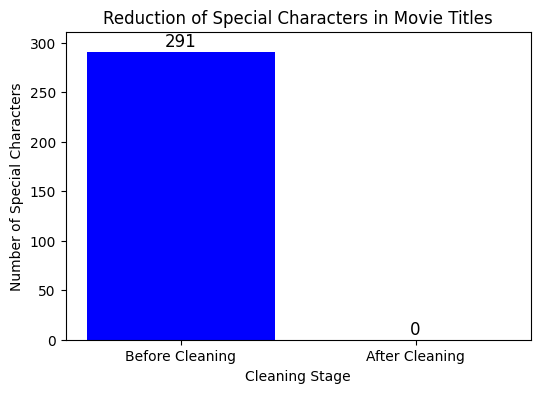

In [70]:
# Data for the bar chart
categories = ['Before Cleaning', 'After Cleaning']
values = [before_cleaning, after_cleaning]

# Create the bar chart
plt.figure(figsize=(6,4))
plt.bar(categories, values, color=['blue', 'green'])
plt.xlabel("Cleaning Stage")
plt.ylabel("Number of Special Characters")
plt.title("Reduction of Special Characters in Movie Titles")
plt.ylim(0, max(values) + 20)  # Add some space above bars for clarity

# Show values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12)

plt.show()

In [14]:
# Save the cleaned data
df_train.to_csv("cleaned_movies.csv", index=False)

In [15]:
df_train.head(20)

,Unnamed: 0,tconst,movieTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Destiny,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,1925,\N,93,17887.0,True
5,42,tt0016630,Battling Butler,1926,\N,77,3285.0,True
6,81,tt0021015,Juno and the Paycock,1929,\N,85,2275.0,False
7,118,tt0023973,The Eagle and the Hawk,1933,\N,73,NaN,True
8,119,tt0023986,Employees Entrance,1933,\N,75,NaN,True
9,123,tt0024184,The Invisible Man,1933,\N,71,33562.0,True
